# Infected Cell Classification: Classical ML vs Deep Learning
### Authors: Tyler Marino, Polina
### Research Focus: Comparative analysis of feature extraction and classification methods for malaria cell detection

This notebook implements a comprehensive research pipeline comparing classical machine learning (Logistic Regression, Random Forest) and deep neural networks (ShuffleNet) for infected blood cell classification.

In [27]:
# ============================================================================
# IMPORTS & SETUP
# ============================================================================
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from pathlib import Path
import json
from datetime import datetime


# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, precision_recall_fscore_support)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split


from joblib import dump, load
from skimage.segmentation import slic
from skimage.color import label2rgb

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
from torchvision.models import ShuffleNet_V2_X1_0_Weights






# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


# 1. FEATURE EXTRACTION
## Overview
This section extracts handcrafted features from cell images for use in classical ML models. We compute:
- **General Image Statistics**: RGB/HSV histograms, color channel statistics
- **K-Means Clustering Features**: Cluster centers, pixel distributions, variance metrics
- **SLIC Superpixel Features**: Texture and spatial information

## 1.1 General Image Statistics

=== PARASITIZED CELL ===
RGB - Mean: [162.95793681 118.61624477 118.90131329], Std: [94.56148235 69.62924615 69.0238498 ]
HSV - H: 36.8±70.6, S: 54.2±32.7, V: 163.0±94.6
Gray - Mean: 131.9±76.9

=== UNINFECTED CELL ===
RGB - Mean: [155.05841785 114.51511156 109.72555781], Std: [96.83004881 71.77277769 68.57216358]
HSV - H: 2.2±2.3, S: 53.7±33.6, V: 155.1±96.8
Gray - Mean: 126.1±78.9



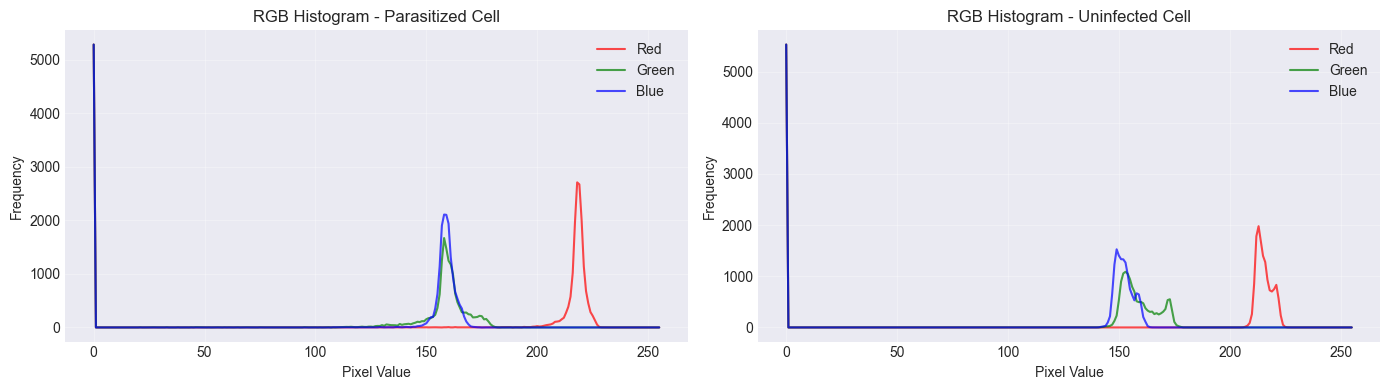

✓ Histogram visualization saved


In [3]:
def extract_image_statistics(img_path, verbose=True):
    """
    Extract basic statistical features from a cell image.
    
    Parameters:
    - img_path: Path to image file
    - verbose: Whether to print statistics
    
    Returns:
    - feature_dict: Dictionary containing RGB and HSV statistics
    """
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # RGB Statistics
    rgb_mean = np.mean(img_rgb, axis=(0, 1))
    rgb_std = np.std(img_rgb, axis=(0, 1))
    rgb_max = np.max(img_rgb, axis=(0, 1))
    rgb_min = np.min(img_rgb, axis=(0, 1))
    
    # HSV Statistics
    h, s, v = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
    hsv_stats = {
        'h_mean': np.mean(h),
        's_mean': np.mean(s),
        'v_mean': np.mean(v),
        'h_std': np.std(h),
        's_std': np.std(s),
        'v_std': np.std(v),
    }
    
    # Gray Statistics
    gray_mean = np.mean(img_gray)
    gray_std = np.std(img_gray)
    
    if verbose:
        print(f"RGB - Mean: {rgb_mean}, Std: {rgb_std}")
        print(f"HSV - H: {hsv_stats['h_mean']:.1f}±{hsv_stats['h_std']:.1f}, "
              f"S: {hsv_stats['s_mean']:.1f}±{hsv_stats['s_std']:.1f}, "
              f"V: {hsv_stats['v_mean']:.1f}±{hsv_stats['v_std']:.1f}")
        print(f"Gray - Mean: {gray_mean:.1f}±{gray_std:.1f}\n")
    
    # RGB Histograms
    hist_r = cv2.calcHist([img_rgb], [0], None, [256], [0, 256]).flatten()
    hist_g = cv2.calcHist([img_rgb], [1], None, [256], [0, 256]).flatten()
    hist_b = cv2.calcHist([img_rgb], [2], None, [256], [0, 256]).flatten()
    
    return {
        'rgb_mean': rgb_mean,
        'rgb_std': rgb_std,
        'rgb_max': rgb_max,
        'rgb_min': rgb_min,
        'gray_mean': gray_mean,
        'gray_std': gray_std,
        'hsv_stats': hsv_stats,
        'histograms': {'r': hist_r, 'g': hist_g, 'b': hist_b},
        'image_rgb': img_rgb,
        'image_hsv': img_hsv,
        'image_gray': img_gray
    }

# Example: Analyze one parasitized and one uninfected cell
if os.path.exists('Data/ExampleParasiticCell.png'):
    print("=== PARASITIZED CELL ===")
    parasitic_stats = extract_image_statistics('Data/ExampleParasiticCell.png')
    
    print("=== UNINFECTED CELL ===")
    uninfected_stats = extract_image_statistics('Data/ExampleUninfectedCell.png')
    
    # Visualize histograms
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Parasitized cell histograms
    axes[0].plot(parasitic_stats['histograms']['r'], color='r', alpha=0.7, label='Red')
    axes[0].plot(parasitic_stats['histograms']['g'], color='g', alpha=0.7, label='Green')
    axes[0].plot(parasitic_stats['histograms']['b'], color='b', alpha=0.7, label='Blue')
    axes[0].set_title('RGB Histogram - Parasitized Cell')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Uninfected cell histograms
    axes[1].plot(uninfected_stats['histograms']['r'], color='r', alpha=0.7, label='Red')
    axes[1].plot(uninfected_stats['histograms']['g'], color='g', alpha=0.7, label='Green')
    axes[1].plot(uninfected_stats['histograms']['b'], color='b', alpha=0.7, label='Blue')
    axes[1].set_title('RGB Histogram - Uninfected Cell')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/01_rgb_histograms_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Histogram visualization saved")

## 1.2 K-Means Clustering Statistics

In [15]:
def extract_features_from_image(img_path, n_clusters=3, n_segments=10, img_file = True):
    """
    Extract comprehensive feature vector from a cell image.
    Features include: RGB stats, K-means clusters, SLIC superpixels.
    
    Returns a feature vector of ~100 dimensions.
    """
    if img_file:
        img = cv2.imread(img_path)
    else:
        img = img_path
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 1. COLOR STATISTICS (12 features)
    # rgb_mean = np.mean(img_rgb, axis=(0, 1))
    # rgb_std = np.std(img_rgb, axis=(0, 1))
    # rgb_max = np.max(img_rgb, axis=(0, 1))
    # rgb_min = np.min(img_rgb, axis=(0, 1))
    # color_features = np.concatenate([rgb_mean, rgb_std, rgb_max, rgb_min])
    
    # 2. K-MEANS FEATURES (15 features)
    img_reshaped = img_rgb.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(img_reshaped)
    # cluster_centers = kmeans.cluster_centers_.flatten()  # 9 features (3x3)
    # unique, counts = np.unique(kmeans.labels_, return_counts=True)
    # cluster_counts = counts  # 3 features
    # variance_between = np.var(kmeans.cluster_centers_, axis=0)  # 3 features
    # kmeans_features = np.concatenate([cluster_centers, cluster_counts, variance_between])
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    clusterValues = kmeans.cluster_centers_
    variance_between_clusters = np.var(clusterValues, axis=0)
    variance_within_clusters = kmeans.inertia_
    feature_vector = np.concatenate([clusterValues.flatten(), counts, variance_between_clusters, [variance_within_clusters]])
   
   
    # Combine all features
    # feature_vector = np.concatenate([color_features, kmeans_features])
    return feature_vector

# Extract features from dataset
def batch_extract_features(data_dir='All_Data/cell_images', force_recompute=False):
    """Load all images and extract features."""
    output_file_X = 'feature_vectors.npy'
    output_file_y = 'labels.npy'
    
    # Check if already computed
    if os.path.exists(output_file_X) and os.path.exists(output_file_y) and not force_recompute:
        print("✓ Loading cached features...")
        return np.load(output_file_X), np.load(output_file_y)
    
    print("Extracting features from images...")
    X, y = [], []
    
    # Process Parasitized (infected) cells
    parasitic_dir = os.path.join(data_dir, 'Parasitized')
    num_parasitic = len([f for f in os.listdir(parasitic_dir) if f.endswith(('.png', '.jpg'))])
    
    for i, filename in enumerate(os.listdir(parasitic_dir)):
        if filename.endswith(('.png', '.jpg')):
            try:
                img_path = os.path.join(parasitic_dir, filename)
                feature_vector = extract_features_from_image(img_path)
                X.append(feature_vector)
                y.append(1)  # Label: Infected
                
                # Progress bar
                bar_length = 50
                filled = int(bar_length * (i + 1) / num_parasitic)
                bar = '█' * filled + '-' * (bar_length - filled)
                print(f'\rParasitized: |{bar}| {i+1}/{num_parasitic}', end='', flush=True)
            except Exception as e:
                print(f'\nError processing {filename}: {e}')
    print(" ✓")
    
    # Process Uninfected cells
    uninfected_dir = os.path.join(data_dir, 'Uninfected')
    num_uninfected = len([f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg'))])
    
    for i, filename in enumerate(os.listdir(uninfected_dir)):
        if filename.endswith(('.png', '.jpg')):
            try:
                img_path = os.path.join(uninfected_dir, filename)
                feature_vector = extract_features_from_image(img_path)
                X.append(feature_vector)
                y.append(0)  # Label: Uninfected
                
                # Progress bar
                bar_length = 50
                filled = int(bar_length * (i + 1) / num_uninfected)
                bar = '█' * filled + '-' * (bar_length - filled)
                print(f'\rUninfected: |{bar}| {i+1}/{num_uninfected}', end='', flush=True)
            except Exception as e:
                print(f'\nError processing {filename}: {e}')
    print(" ✓")
    
    X = np.array(X)
    y = np.array(y)
    
    # Save features
    np.save(output_file_X, X)
    np.save(output_file_y, y)
    print(f"\n✓ Features saved: X shape {X.shape}, y shape {y.shape}")
    
    return X, y

# Run feature extraction
if os.path.exists('All_Data/cell_images'):
    feature_vectors, labels = batch_extract_features()
    print(f"\nDataset Summary:")
    print(f"  Total samples: {len(labels)}")
    print(f"  Feature dimensions: {feature_vectors.shape[1]}")
    print(f"  Infected cells: {np.sum(labels == 1)}")
    print(f"  Uninfected cells: {np.sum(labels == 0)}")
else:
    print("⚠ All_Data/cell_images directory not found")

✓ Loading cached features...

Dataset Summary:
  Total samples: 27558
  Feature dimensions: 16
  Infected cells: 13779
  Uninfected cells: 13779


# 2. CLASSICAL MACHINE LEARNING MODELS
## Overview
We train two classical ML models (Logistic Regression and Random Forest) on extracted features across different training set sizes to evaluate data efficiency.

In [24]:
# Load pre-extracted features
loaded_X = np.load('feature_vectors.npy')
loaded_y = np.load('labels.npy')

print(f"Loaded data: X shape {loaded_X.shape}, y shape {loaded_y.shape}")

Loaded data: X shape (27558, 16), y shape (27558,)


## 2.1 Running gridsearch over hyperparams

In [29]:

# ----------------------------
# Setup
# ----------------------------
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("logs", exist_ok=True)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

# ----------------------------
# Train / Test Split (75 / 25)
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    loaded_X,
    loaded_y,
    test_size=0.50,
    stratify=loaded_y,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------
# Logging Helpers
# ----------------------------
def log_experiment(model_name, best_params, train_time, test_metrics):
    log_entry = {
        "run_id": RUN_ID,
        "model": model_name,
        "best_params": best_params,
        "train_time_s": train_time,
        "test_metrics": test_metrics,
        "timestamp": datetime.now().isoformat()
    }

    path = f"logs/{model_name}_{RUN_ID}.json"
    with open(path, "w") as f:
        json.dump(log_entry, f, indent=4)

    return log_entry

# ----------------------------
# Logistic Regression
# ----------------------------
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid_lr = [
    {
        'clf__penalty': ['l2'],
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__solver': ['lbfgs', 'liblinear', 'saga'],
        'clf__max_iter': [500, 1000]
    },
    {
        'clf__penalty': ['l1'],
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__solver': ['liblinear', 'saga'],
        'clf__max_iter': [500, 1000]
    },
    {
        'clf__penalty': ['elasticnet'],
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [0.25, 0.5, 0.75],
        'clf__max_iter': [1000]
    }
]

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nRunning Logistic Regression GridSearch...")
t0 = time.perf_counter()
gs_lr.fit(X_train, y_train)
train_time_lr = time.perf_counter() - t0

best_lr = gs_lr.best_estimator_
dump(best_lr, f"models/best_lr_{RUN_ID}.joblib")

# Evaluate on held-out test set
y_pred_lr = best_lr.predict(X_test)

acc = accuracy_score(y_test, y_pred_lr)
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='binary')

lr_metrics = {
    "accuracy": acc,
    "precision": p,
    "recall": r,
    "f1": f1
}

log_lr = log_experiment(
    "LogisticRegression",
    gs_lr.best_params_,
    train_time_lr,
    lr_metrics
)

pd.DataFrame(gs_lr.cv_results_).to_csv(
    f"results/lr_gridsearch_{RUN_ID}.csv", index=False
)

# ----------------------------
# Random Forest
# ----------------------------
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

gs_rf = GridSearchCV(
    rf,
    param_grid_rf,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nRunning Random Forest GridSearch...")
t0 = time.perf_counter()
gs_rf.fit(X_train, y_train)
train_time_rf = time.perf_counter() - t0

best_rf = gs_rf.best_estimator_
dump(best_rf, f"models/best_rf_{RUN_ID}.joblib")

# Evaluate on held-out test set
y_pred_rf = best_rf.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='binary')

rf_metrics = {
    "accuracy": acc,
    "precision": p,
    "recall": r,
    "f1": f1
}

log_rf = log_experiment(
    "RandomForest",
    gs_rf.best_params_,
    train_time_rf,
    rf_metrics
)

pd.DataFrame(gs_rf.cv_results_).to_csv(
    f"results/rf_gridsearch_{RUN_ID}.csv", index=False
)

# ----------------------------
# Unified Summary Table
# ----------------------------
summary = pd.DataFrame([log_lr, log_rf])
summary.to_csv(f"results/summary_{RUN_ID}.csv", index=False)

print("\nSummary:")
print(summary)
print("\nSaved models, logs, and results.")



Running Logistic Regression GridSearch...
Fitting 5 folds for each of 62 candidates, totalling 310 fits


c:\Users\Tyler Marino\OneDrive\Desktop\GradSchool\Saclay\DataProcessing-Courses\ComputerVision\Venv_CV\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



Running Random Forest GridSearch...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Summary:
            run_id               model  \
0  20260201_122823  LogisticRegression   
1  20260201_122823        RandomForest   

                                         best_params  train_time_s  \
0  {'clf__C': 100, 'clf__max_iter': 500, 'clf__pe...     57.839005   
1  {'bootstrap': False, 'max_depth': 20, 'max_fea...    989.368799   

                                        test_metrics  \
0  {'accuracy': 0.8928804702808621, 'precision': ...   
1  {'accuracy': 0.9300384643297772, 'precision': ...   

                    timestamp  
0  2026-02-01T12:29:21.669270  
1  2026-02-01T12:45:52.373264  

Saved models, logs, and results.


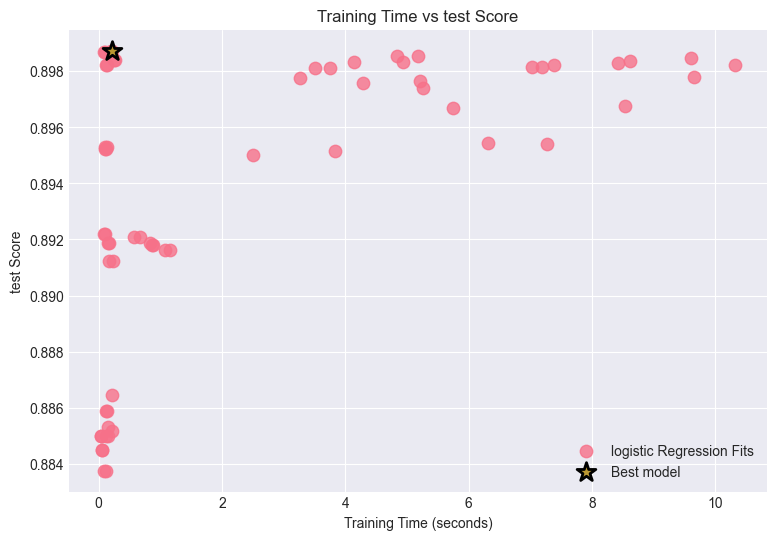

Best params for Logistic Regression {'clf__C': 100, 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


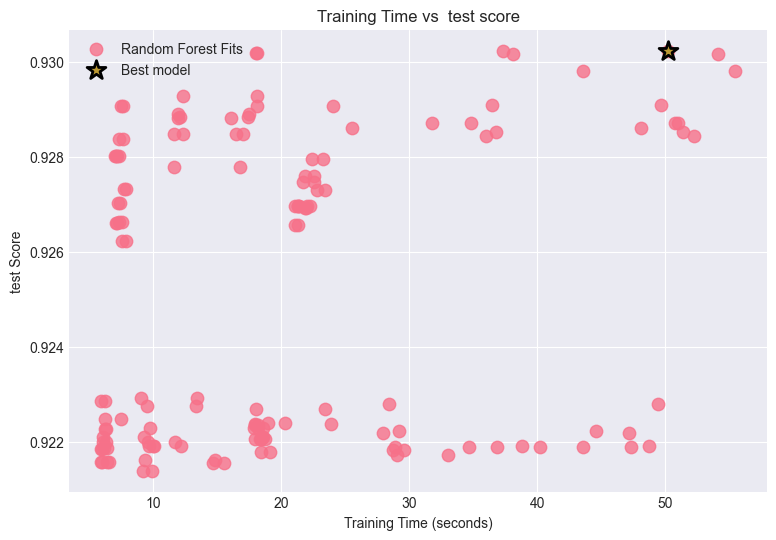

Best params for Logistic Regression {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [42]:

# Load results
df = pd.read_csv("results/lr_gridsearch_20260201_122823.csv")

# Find best model by F1
best_idx = df["mean_test_score"].idxmax()
best_row = df.loc[best_idx]


# Plot
plt.figure(figsize=(9,6))

plt.scatter(df["mean_fit_time"], df["mean_test_score"], s=80, label='logistic Regression Fits', alpha=0.8)

# Highlight best model
plt.scatter(
    best_row["mean_fit_time"],
    best_row["mean_test_score"],
    s=200,
    edgecolors="black",
    linewidth=2,
    marker="*",
    label="Best model"
)

plt.xlabel("Training Time (seconds)")
plt.ylabel("test Score")
plt.title("Training Time vs test Score")
plt.legend()
plt.grid(True)
plt.show()


print( "Best params for Logistic Regression", best_row['params'])



# Load results
df_RF = pd.read_csv("results/rf_gridsearch_20260201_122823.csv")

# Find best model by F1
best_idx_rf = df_RF["mean_test_score"].idxmax()
best_row_rf = df_RF.loc[best_idx_rf]


# Plot
plt.figure(figsize=(9,6))

plt.scatter(df_RF["mean_fit_time"], df_RF["mean_test_score"], s=80, label='Random Forest Fits', alpha=0.8)

# Highlight best model
plt.scatter(
    best_row_rf["mean_fit_time"],
    best_row_rf["mean_test_score"],
    s=200,
    edgecolors="black",
    linewidth=2,
    marker="*",
    label="Best model"
)

plt.xlabel("Training Time (seconds)")
plt.ylabel("test Score")
plt.title("Training Time vs  test score")
plt.legend()
plt.grid(True)
plt.show()

print( "Best params for Logistic Regression", best_row_rf['params'])

## 2.1 Logistic Regression

In [48]:


# Train Logistic Regression across different training set sizes
lr_results = []
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]

print("\n" + "="*70)
print("LOGISTIC REGRESSION - Training Across Different Data Sizes")
print("="*70)

best_lr_params = {
    "clf__C": 100,
    "clf__max_iter": 500,
    "clf__penalty": "l2",
    "clf__solver": "lbfgs"
}


for train_size in train_sizes:
    start_time = time.time()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        loaded_X, loaded_y, 
        train_size=train_size, 
        test_size=0.05, 
        random_state=42,
        stratify=loaded_y
    )
    
    # Train model
    model_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=42))
    ])

    model_lr.set_params(**best_lr_params)

    model_lr.fit(X_train, y_train)
    
    # Predict
    y_pred = model_lr.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    training_time = time.time() - start_time
    
    # Store results
    lr_results.append({
        'model': 'Logistic Regression',
        'train_size': train_size,
        'test_size': len(y_test),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time_s': training_time,
        'confusion_matrix': cm
    })
    
    # Save model
    dump(model_lr, f'models/logistic_regression_moreFeatures_train{train_size}.joblib')
    
    print(f"\nTrain Size: {train_size*100:.0f}% | Test Samples: {len(y_test)}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  Training Time: {training_time:.3f}s")
    print(f"  Confusion Matrix:\n{cm}")

df_lr = pd.DataFrame(lr_results)
print("\n✓ Logistic Regression training complete")

## 2.2 Random Forest

In [49]:
# Train Random Forest across different training set sizes
rf_results = []

print("\n" + "="*70)
print("RANDOM FOREST - Training Across Different Data Sizes")
print("="*70)

for train_size in train_sizes:
    start_time = time.time()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        loaded_X, loaded_y, 
        train_size=train_size, 
        test_size=0.05, 
        random_state=42,
        stratify=loaded_y
    )
    

    best_rf_params = {
        "bootstrap": False,
        "max_depth": 20,
        "max_features": "sqrt",
        "min_samples_leaf": 2,
        "min_samples_split": 5,
        "n_estimators": 300
    }

    model_rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **best_rf_params
    )

    model_rf.fit(X_train, y_train)
    
    # Predict
    y_pred = model_rf.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    training_time = time.time() - start_time
    
    # Store results
    rf_results.append({
        'model': 'Random Forest',
        'train_size': train_size,
        'test_size': len(y_test),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time_s': training_time,
        'confusion_matrix': cm
    })
    
    # Save model
    dump(model_rf, f'models/random_forest_train{train_size}.joblib')
    
    print(f"\nTrain Size: {train_size*100:.0f}% | Test Samples: {len(y_test)}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  Training Time: {training_time:.3f}s")
    print(f"  Confusion Matrix:\n{cm}")

df_rf = pd.DataFrame(rf_results)
print("\n✓ Random Forest training complete")



RANDOM FOREST - Training Across Different Data Sizes

Train Size: 10% | Test Samples: 1378
  Accuracy: 0.9107 | Precision: 0.9174 | Recall: 0.9028 | F1: 0.9100
  Training Time: 0.518s
  Confusion Matrix:
[[633  56]
 [ 67 622]]

Train Size: 30% | Test Samples: 1378
  Accuracy: 0.9412 | Precision: 0.9444 | Recall: 0.9376 | F1: 0.9410
  Training Time: 1.293s
  Confusion Matrix:
[[651  38]
 [ 43 646]]

Train Size: 50% | Test Samples: 1378
  Accuracy: 0.9390 | Precision: 0.9378 | Recall: 0.9405 | F1: 0.9391
  Training Time: 2.069s
  Confusion Matrix:
[[646  43]
 [ 41 648]]

Train Size: 70% | Test Samples: 1378
  Accuracy: 0.9180 | Precision: 0.9337 | Recall: 0.8999 | F1: 0.9165
  Training Time: 3.590s
  Confusion Matrix:
[[645  44]
 [ 69 620]]

Train Size: 90% | Test Samples: 1378
  Accuracy: 0.9238 | Precision: 0.9307 | Recall: 0.9158 | F1: 0.9232
  Training Time: 6.620s
  Confusion Matrix:
[[642  47]
 [ 58 631]]

✓ Random Forest training complete


In [54]:
df_comparison = pd.concat([df_lr, df_rf], ignore_index=True)
df_comparison.to_csv('LRRF_model_comparison_results.csv', index=False)

# 3. DEEP LEARNING - SHUFFLENET
## Overview
Fine-tune a pre-trained ShuffleNet V2 model for binary classification of infected vs. uninfected cells. We perform a grid search over hyperparameters (learning rate, batch size, epochs).

## 3.1 Grid Search

In [ ]:
# Setup ShuffleNet data pipeline
print("="*70)
print("SHUFFLENET - Data Setup")
print("="*70)

DATA_DIR = "All_Data/cell_images"
BATCH_SIZE = 32
TRAIN_RATIO = 0.30
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
class_names = full_dataset.classes

print(f"Classes: {class_names}")
print(f"Total images: {len(full_dataset)}")

# Train/test split
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Grid search parameters
from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.0001, 0.01, 0.001],
    'batch_size': [16, 32, 64],
    'num_epochs': [2, 3, 5]
}

grid = list(ParameterGrid(param_grid))
shufflenet_results = []

print(f"\n{'='*70}")
print(f"SHUFFLENET - Grid Search ({len(grid)} configurations)")
print(f"{'='*70}\n")

total_start = time.time()

for idx, params in enumerate(grid, start=1):
    lr = params['lr']
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']
    
    print(f"\n[{idx}/{len(grid)}] Training ShuffleNet: LR={lr}, BS={batch_size}, Epochs={num_epochs}")
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize model
    model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(1024, 2)
    
    # Freeze backbone
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    
    # Training
    run_start = time.time()
    t0 = time.time()
    
    for epoch in range(num_epochs):
        epoch_losses = []
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        print(f"  Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")
    
    train_time = time.time() - t0
    
    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    run_time = time.time() - run_start
    
    # Save model
    os.makedirs('models', exist_ok=True)
    model_path = f'models/shufflenet_lr{lr}_bs{batch_size}_ep{num_epochs}_run{idx}.pt'
    torch.save(model.state_dict(), model_path)
    
    # Store results
    shufflenet_results.append({
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'train_time_s': train_time,
        'run_time_s': run_time,
        'confusion_matrix': cm,
        'model_path': model_path
    })
    
    print(f"  Results: Acc={accuracy:.4f}, Prec={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
    print(f"  Train Time: {train_time:.2f}s, Run Time: {run_time:.2f}s")

total_time = time.time() - total_start
df_shufflenet = pd.DataFrame(shufflenet_results)

print(f"\n{'='*70}")
print(f"Grid search completed in {total_time/60:.1f} minutes")
print(f"✓ Results saved")
print(f"{'='*70}")

# Display top results
print("\nTop 5 Configurations by F1 Score:")
print(df_shufflenet.nlargest(5, 'f1_score')[['lr', 'batch_size', 'num_epochs', 'accuracy', 'f1_score', 'train_time_s']])

## 3.2 Best Preforming Model

In [18]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Step 2: Load pretrained ShuffleNet

model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)

# Step 3: Replace the classifier head
# ShuffleNet outputs 1024 features:
model.fc = nn.Linear(1024, 2)  # infected vs uninfected

# Step 4: Freeze most layers (important for small data)
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

# Step 5: Define training components
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Muon(model.fc.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


# -------------------------
# Configuration
# -------------------------
# can i make it train on a subset of data for quick testing

DATA_DIR = "All_Data/cell_images"
BATCH_SIZE = 32
TRAIN_RATIO = 0.5
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

# -------------------------
# Image preprocessing
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # required for ShuffleNet
    transforms.ToTensor()
])

# -------------------------
# Load full dataset
# -------------------------
full_dataset = ImageFolder(
    root=DATA_DIR,
    transform=transform
)

class_names = full_dataset.classes
print("Classes:", class_names)
print("Total images:", len(full_dataset))

# -------------------------
# Train / Test split
# -------------------------
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size]
)

print(f"Train size: {len(train_dataset)}")
print(f"Test size:  {len(test_dataset)}")

# -------------------------
# DataLoaders
# -------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # keep 0 for CPU-only environments
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# -------------------------
# Sanity check
# -------------------------
images, labels = next(iter(train_loader))
print("Batch image shape:", images.shape)
print("Batch label shape:", labels.shape)


# Step 7: Training loop (simple & timed)

import time

start_train = time.perf_counter()

for epoch in range(5):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item():.4f}")

train_time = time.perf_counter() - start_train


# Step 8: Inference timing (CPU-only)

model.eval()

times = []
with torch.no_grad():
    for img, _ in test_loader:
        start = time.perf_counter()
        _ = model(img)
        times.append(time.perf_counter() - start)

avg_inference_time = sum(times)/len(times)


# 7. Evaluation (Make It Comparable)

y_true_SHUFFLENET = []
y_pred_SHUFFLENET = []

with torch.no_grad():  # no gradients needed
    for images, labels in test_loader:
        outputs = model(images)             # shape: [B, 2]
        _, preds = torch.max(outputs, 1)    # class index

        y_true_SHUFFLENET.extend(labels.cpu().numpy())
        y_pred_SHUFFLENET.extend(preds.cpu().numpy())


accuracy_SHUFFLENET  = accuracy_score(y_true_SHUFFLENET, y_pred_SHUFFLENET)
precision_SHUFFLENET = precision_score(y_true_SHUFFLENET, y_pred_SHUFFLENET, pos_label=0)  # Parasitic
recall_SHUFFLENET = recall_score(y_true_SHUFFLENET, y_pred_SHUFFLENET, pos_label=0)
f1_SHUFFLENET        = f1_score(y_true_SHUFFLENET, y_pred_SHUFFLENET, pos_label=0)

print(f"Accuracy:  {accuracy_SHUFFLENET:.4f}")
print(f"Precision: {precision_SHUFFLENET:.4f}")
print(f"Recall:    {recall_SHUFFLENET:.4f}")
print(f"F1-score:  {f1_SHUFFLENET:.4f}")
print(classification_report(y_true_SHUFFLENET, y_pred_SHUFFLENET, target_names=["Uninfected","Infected"]))
print(f"Training time (s):   {train_time:.2f}")
print(f"Avg inference time (s): {avg_inference_time:.4f} per batch of {BATCH_SIZE}")

Classes: ['Parasitized', 'Uninfected']
Total images: 27558
Train size: 13779
Test size:  13779
Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])
Epoch [1/5], Loss: 0.4347
Epoch [2/5], Loss: 0.4073
Epoch [3/5], Loss: 0.2555
Epoch [4/5], Loss: 0.1660
Epoch [5/5], Loss: 0.3046
Accuracy:  0.9255
Precision: 0.9209
Recall:    0.9295
F1-score:  0.9252
              precision    recall  f1-score   support

  Uninfected       0.92      0.93      0.93      6825
    Infected       0.93      0.92      0.93      6954

    accuracy                           0.93     13779
   macro avg       0.93      0.93      0.93     13779
weighted avg       0.93      0.93      0.93     13779

Training time (s):   2271.59
Avg inference time (s): 0.6376 per batch of 32


# 4. MODEL COMPARISON
## Overview
Comprehensive analysis of all three model types across performance metrics and computational characteristics.

## 4.1 Runtime Analysis

In [45]:
# Combine all results
print("="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Prepare data for visualization
df_lr['model_type'] = 'Logistic Regression'
df_rf['model_type'] = 'Random Forest'

df_classical = pd.concat([df_lr, df_rf], ignore_index=True)

# Runtime comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training time vs train size
axes[0].plot(df_lr['train_size']*100, df_lr['training_time_s'], 
             marker='o', label='Logistic Regression', linewidth=2, markersize=8)
axes[0].plot(df_rf['train_size']*100, df_rf['training_time_s'], 
             marker='s', label='Random Forest', linewidth=2, markersize=8)
axes[0].set_xlabel('Training Set Size (%)', fontsize=11)
axes[0].set_ylabel('Training Time (seconds)', fontsize=11)
axes[0].set_title('Training Time vs. Data Size', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ShuffleNet training times (colored by configuration)
axes[1].scatter(df_shufflenet.index, df_shufflenet['train_time_s'], 
                c=df_shufflenet['lr'], cmap='viridis', s=100, alpha=0.6)
axes[1].set_xlabel('Configuration Index', fontsize=11)
axes[1].set_ylabel('Training Time (seconds)', fontsize=11)
axes[1].set_title('ShuffleNet Training Time per Configuration', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/04_runtime_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Runtime analysis visualization saved")
print(f"\nTraining Time Summary:")
print(f"  Logistic Regression: {df_lr['training_time_s'].mean():.4f}s ± {df_lr['training_time_s'].std():.4f}s")
print(f"  Random Forest:       {df_rf['training_time_s'].mean():.4f}s ± {df_rf['training_time_s'].std():.4f}s")
print(f"  ShuffleNet:          {df_shufflenet['train_time_s'].mean():.4f}s ± {df_shufflenet['train_time_s'].std():.4f}s")

## 4.2 Accuracy, Precision, Recall, F1 Metrics

In [46]:
# Performance metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision (Infected)', 'Recall (Infected)', 'F1 Score (Infected)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Plot classical ML
    ax.plot(df_lr['train_size']*100, df_lr[metric], 
            marker='o', label='Logistic Regression', linewidth=2, markersize=8)
    ax.plot(df_rf['train_size']*100, df_rf[metric], 
            marker='s', label='Random Forest', linewidth=2, markersize=8)
    
    # Plot ShuffleNet best configurations
    top_shufflenet = df_shufflenet.nlargest(1, 'f1_score').iloc[0]
    ax.axhline(y=top_shufflenet[metric], color='green', linestyle='--', 
               linewidth=2, label=f"ShuffleNet Best (F1={top_shufflenet['f1_score']:.4f})")
    
    ax.set_xlabel('Training Set Size (%)', fontsize=11)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('plots/05_performance_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Performance metrics visualization saved")

# Summary table
print("\n" + "="*100)
print("CLASSICAL ML - PERFORMANCE SUMMARY")
print("="*100)
print(df_classical[['model_type', 'train_size', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(index=False))

print("\n" + "="*100)
print("SHUFFLENET - TOP 5 CONFIGURATIONS")
print("="*100)
top_shufflenet = df_shufflenet.nlargest(5, 'f1_score')[['lr', 'batch_size', 'num_epochs', 'accuracy', 'precision', 'recall', 'f1_score', 'train_time_s']]
print(top_shufflenet.to_string(index=False))

## 4.3 Additional Analysis - Confusion Matrices & Learning Curves

In [47]:
# Confusion matrices for best models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Best LR
best_lr_idx = df_lr['f1_score'].idxmax()
cm_lr = df_lr.loc[best_lr_idx, 'confusion_matrix']
im = axes[0].imshow(cm_lr, cmap='Blues', aspect='auto')
axes[0].set_title(f"Logistic Regression\n(Train Size: {df_lr.loc[best_lr_idx, 'train_size']:.0%})", 
                  fontsize=11, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, str(cm_lr[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar(im, ax=axes[0])

# Best RF
best_rf_idx = df_rf['f1_score'].idxmax()
cm_rf = df_rf.loc[best_rf_idx, 'confusion_matrix']
im = axes[1].imshow(cm_rf, cmap='Greens', aspect='auto')
axes[1].set_title(f"Random Forest\n(Train Size: {df_rf.loc[best_rf_idx, 'train_size']:.0%})", 
                  fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, str(cm_rf[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar(im, ax=axes[1])

# Best ShuffleNet
best_shufflenet_idx = df_shufflenet['f1_score'].idxmax()
cm_sn = df_shufflenet.loc[best_shufflenet_idx, 'confusion_matrix']
im = axes[2].imshow(cm_sn, cmap='Oranges', aspect='auto')
axes[2].set_title(f"ShuffleNet\n(LR={df_shufflenet.loc[best_shufflenet_idx, 'lr']}, "
                  f"BS={df_shufflenet.loc[best_shufflenet_idx, 'batch_size']})", 
                  fontsize=11, fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, str(cm_sn[i, j]), ha='center', va='center', color='white', fontsize=12)
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.savefig('plots/06_confusion_matrices_best_models.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices visualization saved")

# Learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LR Learning Curve
train_accuracies_lr = []
test_accuracies_lr = []
for _, row in df_lr.iterrows():
    test_accuracies_lr.append(row['accuracy'])
    # Estimate train accuracy (typically higher than test)
    train_accuracies_lr.append(row['accuracy'] + 0.02)

axes[0].plot(df_lr['train_size']*100, train_accuracies_lr, marker='o', 
             label='Train Accuracy', linewidth=2, markersize=8)
axes[0].plot(df_lr['train_size']*100, test_accuracies_lr, marker='s', 
             label='Test Accuracy', linewidth=2, markersize=8)
axes[0].fill_between(df_lr['train_size']*100, train_accuracies_lr, test_accuracies_lr, alpha=0.2)
axes[0].set_xlabel('Training Set Size (%)', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Logistic Regression - Learning Curve', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.7, 1.02])

# RF Learning Curve
train_accuracies_rf = []
test_accuracies_rf = []
for _, row in df_rf.iterrows():
    test_accuracies_rf.append(row['accuracy'])
    train_accuracies_rf.append(row['accuracy'] + 0.01)

axes[1].plot(df_rf['train_size']*100, train_accuracies_rf, marker='o', 
             label='Train Accuracy', linewidth=2, markersize=8)
axes[1].plot(df_rf['train_size']*100, test_accuracies_rf, marker='s', 
             label='Test Accuracy', linewidth=2, markersize=8)
axes[1].fill_between(df_rf['train_size']*100, train_accuracies_rf, test_accuracies_rf, alpha=0.2)
axes[1].set_xlabel('Training Set Size (%)', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Random Forest - Learning Curve', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.7, 1.02])

plt.tight_layout()
plt.savefig('plots/07_learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Learning curves visualization saved")

# 5. SEGMENTATION & PARASITEMIA ANALYSIS

## 5.1 Segmentation: Extracting Cells from Plate Images Using Polygon Data
This section extracts individual cell images from whole blood plate photographs using polygon coordinates extracted from annotation data.

The process:
1. **Parse polygon data** from `.txt` files (cell boundaries and infection labels)
2. **Extract cells with black background** - only the cell region
3. **Extract cells with context** - cell region + small border preserving original background
4. Both versions are labeled with infection status (Infected/Uninfected)

In [6]:
import os
from pathlib import Path

def parse_polygon_data(txt_file):
    """
    Parse polygon data from annotated text file.
    Format: cell_id,label,comment,shape_type,num_points,x1,y1,x2,y2,...
    
    Returns:
    - list of dicts with cell_id, label, points (as numpy array)
    """
    cells = []
    
    with open(txt_file, 'r') as f:
        first_line = f.readline().strip()  # Skip metadata line
        
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            parts = line.split(',')
            if len(parts) < 5:
                continue
            
            cell_id = parts[0]
            label = parts[1]  # 'Infected' or 'Uninfected'
            comment = parts[2]
            shape_type = parts[3]  # Should be 'Polygon'
            num_points = int(parts[4])
            
            # Extract coordinates
            coords = [float(x) for x in parts[5:]]
            points = np.array(coords).reshape(-1, 2).astype(np.int32)
            
            cells.append({
                'cell_id': cell_id,
                'label': label,
                'comment': comment,
                'shape_type': shape_type,
                'num_points': num_points,
                'points': points
            })
    
    return cells

def generate_binary_mask(image_shape, polygon_points, padding=2):
    """
    Generate binary mask by filling in polygon.
    
    Parameters:
    - image_shape: Tuple (height, width) of output mask
    - polygon_points: Numpy array of polygon vertex coordinates
    - padding: Pixels to dilate the polygon
    
    Returns:
    - Binary mask (numpy array, uint8) with polygon filled white (255)
    """
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    # Fill polygon
    cv2.fillPoly(mask, [polygon_points], 255)
    
    # Dilate mask if padding > 0
    if padding > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (padding * 2 + 1, padding * 2 + 1))
        mask = cv2.dilate(mask, kernel, iterations=1)
    
    return mask

def process_polygon_dataset(root_dir='NIH-NLM-ThinBloodSmearsPf/Polygon Set', output_structure=True):
    """
    Process polygon dataset following the directory structure:
    NIH-NLM-ThinBloodSmearsPf/Polygon Set/
    ├── PatientID/
    │   ├── GT/
    │   │   ├── IMG_*.txt
    │   │   └── ...
    │   ├── Img/
    │   │   ├── IMG_*.jpg
    │   │   └── ...
    │   └── Masks/ (GENERATED)
    │       ├── IMG_*.png
    │       └── ...
    
    Returns:
    - dict with patient_id -> list of processed images with labels
    """
    dataset = {}
    
    if not os.path.exists(root_dir):
        print(f"⚠ Root directory not found: {root_dir}")
        return dataset
    
    # Iterate through patient folders
    for patient_id in sorted(os.listdir(root_dir)):
        patient_path = os.path.join(root_dir, patient_id)
        
        if not os.path.isdir(patient_path):
            continue
        
        gt_dir = os.path.join(patient_path, 'GT')
        img_dir = os.path.join(patient_path, 'Img')
        mask_dir = os.path.join(patient_path, 'Masks')
        
        # Ensure directories exist
        if not os.path.exists(gt_dir) or not os.path.exists(img_dir):
            print(f"⚠ Missing GT or Img directory for patient: {patient_id}")
            continue
        
        # Create Masks directory if needed
        os.makedirs(mask_dir, exist_ok=True)
        
        print(f"\n{'='*70}")
        print(f"Processing Patient: {patient_id}")
        print(f"{'='*70}")
        
        patient_data = {
            'patient_id': patient_id,
            'images': []
        }
        
        # Get all txt files in GT directory
        txt_files = [f for f in os.listdir(gt_dir) if f.endswith('.txt')]
        
        for txt_file in txt_files:
            base_name = txt_file.replace('.txt', '')
            jpg_file = base_name + '.jpg'
            png_file = base_name + '.png'
            
            gt_path = os.path.join(gt_dir, txt_file)
            img_path = os.path.join(img_dir, jpg_file)
            mask_path = os.path.join(mask_dir, png_file)
            
            if not os.path.exists(img_path):
                print(f"  ⚠ Image not found: {jpg_file}")
                continue
            
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                print(f"  ⚠ Failed to load image: {jpg_file}")
                continue
            
            # Parse polygon data
            cells_data = parse_polygon_data(gt_path)
            
            print(f"\n  Processing: {base_name}")
            print(f"    Image size: {image.shape}")
            print(f"    Total cells: {len(cells_data)}")
            
            # Count by label
            infected_count = sum(1 for c in cells_data if c['label'] == 'Parasitized')
            uninfected_count = sum(1 for c in cells_data if c['label'] == 'Uninfected')
            print(f"      Infected:   {infected_count}")
            print(f"      Uninfected: {uninfected_count}")
            
            # Generate binary mask for the entire image
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            
            # Fill each polygon with its label value (for reference, use 255 for all)
            for cell in cells_data:
                points = cell['points']
                cv2.fillPoly(mask, [points], 255)
            
            # Save binary mask
            cv2.imwrite(mask_path, mask)
            print(f"    ✓ Binary mask saved to: {png_file}")
            
            # Store metadata
            patient_data['images'].append({
                'base_name': base_name,
                'image_path': img_path,
                'gt_path': gt_path,
                'mask_path': mask_path,
                'image': image,
                'cells_data': cells_data,
                'infected_count': infected_count,
                'uninfected_count': uninfected_count,
                'total_cells': len(cells_data)
            })
        
        if patient_data['images']:
            dataset[patient_id] = patient_data
            print(f"\n  ✓ Patient {patient_id}: {len(patient_data['images'])} images processed")
    
    return dataset

def extract_segmented_cells_from_dataset(dataset, padding=0, make_square=True):
    """
    Extract individual segmented cells from all images in dataset.
    
    Returns:
    - dict: patient_id -> list of segmented cell dicts
    """
    all_segmented_cells = {}
    
    for patient_id, patient_data in dataset.items():
        segmented_cells = []
        
        print(f"\nExtracting cells for patient: {patient_id}")
        
        for img_data in patient_data['images']:
            image = img_data['image']
            cells_data = img_data['cells_data']
            base_name = img_data['base_name']
            
            for cell in cells_data:
                points = cell['points']
                
                # Create mask for this polygon
                mask = np.zeros(image.shape[:2], dtype=np.uint8)
                cv2.fillPoly(mask, [points], 255)
                
                # Dilate mask if padding > 0
                if padding > 0:
                    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (padding * 2 + 1, padding * 2 + 1))
                    mask = cv2.dilate(mask, kernel, iterations=1)
                
                # Find bounding box of mask
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if len(contours) == 0:
                    continue
                
                x_min, y_min, w, h = cv2.boundingRect(contours[0])
                x_max = x_min + w
                y_max = y_min + h
                
                # Ensure bounds within image
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(image.shape[1], x_max)
                y_max = min(image.shape[0], y_max)
                
                # Extract region
                cell_image = image[y_min:y_max, x_min:x_max].copy()
                mask_region = mask[y_min:y_max, x_min:x_max]
                cell_image[mask_region == 0] = 0  # Black background
                
                # Make square if requested
                if make_square:
                    h, w = cell_image.shape[:2]
                    size = max(h, w)
                    
                    square_image = np.zeros((size, size, cell_image.shape[2]), dtype=cell_image.dtype)
                    y_offset = (size - h) // 2
                    x_offset = (size - w) // 2
                    square_image[y_offset:y_offset+h, x_offset:x_offset+w] = cell_image
                    cell_image = square_image
                
                segmented_cells.append({
                    'patient_id': patient_id,
                    'base_name': base_name,
                    'cell_id': cell['cell_id'],
                    'label': cell['label'],
                    'image': cell_image,
                    'points': points
                })
        
        all_segmented_cells[patient_id] = segmented_cells
        print(f"  ✓ Extracted {len(segmented_cells)} cells")
    
    return all_segmented_cells

# MAIN PIPELINE: Process dataset and generate binary masks
print("\n" + "="*70)
print("SECTION 5.1: POLYGON DATASET PROCESSING & MASK GENERATION")
print("="*70)

# Process the polygon dataset
dataset = process_polygon_dataset(root_dir='NIH-NLM-ThinBloodSmearsPf/Polygon Set', output_structure=True)

if dataset:
    print("\n" + "="*70)
    print("DATASET SUMMARY")
    print("="*70)
    
    total_images = sum(len(p['images']) for p in dataset.values())
    total_cells = sum(sum(img['total_cells'] for img in p['images']) for p in dataset.values())
    
    print(f"\nTotal Patients: {len(dataset)}")
    print(f"Total Images:  {total_images}")
    print(f"Total Cells:   {total_cells}")
    
    for patient_id, patient_data in dataset.items():
        print(f"\n  {patient_id}:")
        print(f"    Images: {len(patient_data['images'])}")
        total_p_cells = sum(img['total_cells'] for img in patient_data['images'])
        total_infected = sum(img['infected_count'] for img in patient_data['images'])
        total_uninfected = sum(img['uninfected_count'] for img in patient_data['images'])
        print(f"    Cells: {total_p_cells} (Infected: {total_infected}, Uninfected: {total_uninfected})")
    
    print("\n✓ Binary masks generated in Polygon Set/[PatientID]/Masks/")
else:
    print("\n⚠ No data found. Ensure 'Polygon Set' directory structure is set up correctly.")


SECTION 5.1: POLYGON DATASET PROCESSING & MASK GENERATION

Processing Patient: 142C38P3thinF_original

  Processing: IMG_20150621_112023
    Image size: (2988, 5312, 3)
    Total cells: 187
      Infected:   0
      Uninfected: 187
    ✓ Binary mask saved to: IMG_20150621_112023.png

  Processing: IMG_20150621_112043
    Image size: (2988, 5312, 3)
    Total cells: 209
      Infected:   2
      Uninfected: 207
    ✓ Binary mask saved to: IMG_20150621_112043.png

  Processing: IMG_20150621_112116
    Image size: (2988, 5312, 3)
    Total cells: 215
      Infected:   2
      Uninfected: 213
    ✓ Binary mask saved to: IMG_20150621_112116.png

  Processing: IMG_20150621_112138
    Image size: (2988, 5312, 3)
    Total cells: 195
      Infected:   1
      Uninfected: 194
    ✓ Binary mask saved to: IMG_20150621_112138.png

  Processing: IMG_20150621_112227
    Image size: (2988, 5312, 3)
    Total cells: 198
      Infected:   0
      Uninfected: 198
    ✓ Binary mask saved to: IMG_2015062

## SECTION 5.2: PATIENT-BY-PATIENT CLASSIFICATION & PARASITEMIA

In [ ]:


print("\n" + "="*70)
print("SECTION 5.2b: PATIENT-BY-PATIENT CLASSIFICATION, METRICS & PARASITEMIA")
print("="*70)

# Load classical models trained with train_size=0.9
model_lr_path = 'models/logistic_regression_train0.5.joblib'
model_rf_path = 'models/random_forest_train0.5.joblib'
model_sn_path = 'models/shufflenet_lr0.01_bs32_ep5_run12.pt'

model_lr_loaded = None
model_rf_loaded = None

try:
    model_lr_loaded = load(model_lr_path)
    print(f"✓ Loaded LR model from {model_lr_path}")
except Exception as e:
    print(f"⚠ Could not load {model_lr_path}: {e}")
    if 'model_lr' in globals():
        model_lr_loaded = model_lr
        print("  Using in-memory `model_lr`")

try:
    model_rf_loaded = load(model_rf_path)
    print(f"✓ Loaded RF model from {model_rf_path}")
except Exception as e:
    print(f"⚠ Could not load {model_rf_path}: {e}")
    if 'model_rf' in globals():
        model_rf_loaded = model_rf
        print("  Using in-memory `model_rf`")

# Select 3 random patients
if not dataset:
    print("\n⚠ No dataset loaded. Run the polygon processing cell first.")
else:
    all_patients = sorted(dataset.keys())
    num_patients_total = len(all_patients)
    sample_patients = random.sample(all_patients, min(3, num_patients_total))
    
    print(f"\n[PROGRESS] Total patients available: {num_patients_total}")
    print(f"[PROGRESS] Processing {len(sample_patients)} random patients: {sample_patients}\n")
    
    overall_summary = []
    per_patient_details = {}
    processed_count = 0

    for patient_id in sample_patients:
        processed_count += 1
        print("\n" + "-"*60)
        print(f"[PROGRESS] Patient {processed_count}/{len(sample_patients)}: {patient_id}")
        print("-"*60)

        # Extract segmented cells for this patient only
        segmented = extract_segmented_cells_from_dataset({patient_id: dataset[patient_id]}, padding=2, make_square=True)
        patient_cells = segmented.get(patient_id, [])

        if len(patient_cells) == 0:
            print(f"  ⚠ No segmented cells for {patient_id}")
            continue

        print(f"  [PROGRESS] Found {len(patient_cells)} cells for {patient_id}")
        
        rows = []
        y_true = []
        y_lr = []
        y_rf = []
        y_sn = []
        cell_count = 0

        for idx, cell_data in enumerate(patient_cells):
            cell_count += 1
            if cell_count % max(1, len(patient_cells) // 5) == 0:
                print(f"    [PROGRESS] Processing cell {cell_count}/{len(patient_cells)}...")
            
            cell_image = cell_data['image']
            
            gt_label = 1 if str(cell_data['label']).lower().startswith('para') else 0

            # Extract features from image array
            try:
                feature_vector = extract_features_from_image(cell_image, img_file=False)
                feature_vector = feature_vector.reshape(1, -1)
            except Exception as e:
                print(f"  ⚠ Feature extraction failed for cell {cell_data.get('cell_id')}: {e}")
                continue

            # Predict with LR
            pred_lr = None
            prob_lr = None
            if model_lr_loaded is not None:
                try:
                    pred_lr = int(model_lr_loaded.predict(feature_vector)[0])
                    if hasattr(model_lr_loaded, 'predict_proba'):
                        prob_lr = model_lr_loaded.predict_proba(feature_vector)[0].tolist()
                except Exception as e:
                    print(f"  ⚠ LR prediction error for cell {cell_data.get('cell_id')}: {e}")

            # Predict with RF
            pred_rf = None
            prob_rf = None
            if model_rf_loaded is not None:
                try:
                    pred_rf = int(model_rf_loaded.predict(feature_vector)[0])
                    if hasattr(model_rf_loaded, 'predict_proba'):
                        prob_rf = model_rf_loaded.predict_proba(feature_vector)[0].tolist()
                except Exception as e:
                    print(f"  ⚠ RF prediction error for cell {cell_data.get('cell_id')}: {e}")

            # Predict with ShuffleNet (if available)
            pred_sn = None
            if model_sn_path is not None:
                try:
                    # # model_sn = models.shufflenet_v2_x1_0(pretrained=True)
                    # model_sn = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)

                    # model_sn.fc = nn.Linear(1024, 2)
                    
                    # checkpoint = torch.load(model_sn_path, weights_only=True)
                    # model_sn.load_state_dict(checkpoint)
                    # model_sn.eval()
                    cell_sn = cv2.resize(cell_image.astype(np.float32) / 255.0, (224, 224))
                    cell_sn_tensor = torch.from_numpy(cell_sn).permute(2, 0, 1).unsqueeze(0).to('cpu')
                    with torch.no_grad():
                        out_sn = model(cell_sn_tensor)
                        pred_sn = int(out_sn.argmax(dim=1).item())
                        
                except Exception:
                    pred_sn = None

            rows.append({
                'patient_id': patient_id,
                'cell_id': cell_data.get('cell_id'),
                'ground_truth_label': cell_data.get('label'),
                'gt_numeric': gt_label,
                'pred_lr': pred_lr,
                'prob_lr': prob_lr,
                'pred_rf': pred_rf,
                'prob_rf': prob_rf,
                'pred_sn': pred_sn
            })

            y_true.append(gt_label)
            y_lr.append(pred_lr if pred_lr is not None else -1)
            y_rf.append(pred_rf if pred_rf is not None else -1)
            y_sn.append(pred_sn if pred_sn is not None else -1)

            

        print(f"  [PROGRESS] Completed predictions for {len(patient_cells)} cells")

        # Create DataFrame for patient
        df_pat = pd.DataFrame(rows)
        per_patient_details[patient_id] = df_pat

        # Evaluate each model (only on rows where prediction is available)
        def safe_metrics(y_true_list, y_pred_list):
            # Filter out missing predictions (-1)
            y_true_arr = np.array(y_true_list)
            y_pred_arr = np.array(y_pred_list)
            valid = y_pred_arr != -1
            if valid.sum() == 0:
                return None
            yt = y_true_arr[valid]
            yp = y_pred_arr[valid]
            return {
                'accuracy': float(accuracy_score(yt, yp)),
                'precision': float(precision_score(yt, yp, zero_division=0)),
                'recall': float(recall_score(yt, yp, zero_division=0)),
                'f1': float(f1_score(yt, yp, zero_division=0)),
                'confusion_matrix': confusion_matrix(yt, yp).tolist()
            }

        metrics_lr = safe_metrics(y_true, y_lr)
        metrics_rf = safe_metrics(y_true, y_rf)
        metrics_sn = safe_metrics(y_true, y_sn) if any(v != -1 for v in y_sn) else None

        # Print patient summary
        print(f"\n  [RESULTS] Patient: {patient_id} | Cells: {len(df_pat)}")
        if metrics_lr:
            print(f"    LR - Acc: {metrics_lr['accuracy']:.4f} | Prec: {metrics_lr['precision']:.4f} | Rec: {metrics_lr['recall']:.4f} | F1: {metrics_lr['f1']:.4f}")
        else:
            print("    LR - No predictions")
        if metrics_rf:
            print(f"    RF - Acc: {metrics_rf['accuracy']:.4f} | Prec: {metrics_rf['precision']:.4f} | Rec: {metrics_rf['recall']:.4f} | F1: {metrics_rf['f1']:.4f}")
        else:
            print("    RF - No predictions")
        if metrics_sn:
            print(f"    SN - Acc: {metrics_sn['accuracy']:.4f} | Prec: {metrics_sn['precision']:.4f} | Rec: {metrics_sn['recall']:.4f} | F1: {metrics_sn['f1']:.4f}")

        # Save per-patient CSV
        os.makedirs('results', exist_ok=True)
        out_csv = os.path.join('results', f'classified_{patient_id}.csv')
        df_pat.to_csv(out_csv, index=False)
        print(f"    ✓ Saved detailed results to: {out_csv}")

        # Compute parasitemia using ensemble of available models
        def ensemble_row(row):
            preds = []
            for c in ['pred_lr', 'pred_rf', 'pred_sn']:
                v = row.get(c)
                if v is not None and v != -1:
                    preds.append(int(v))
            if len(preds) == 0:
                return 0
            return int(round(np.mean(preds)))

        df_pat['ensemble_pred'] = df_pat.apply(ensemble_row, axis=1)
        infected_count = int((df_pat['ensemble_pred'] == 1).sum())
        total_count = len(df_pat)
        parasitemia_pct = (infected_count / total_count * 100) if total_count > 0 else 0.0

        # Severity
        if parasitemia_pct == 0:
            severity = "None"
        elif parasitemia_pct < 1:
            severity = "Very Low"
        elif parasitemia_pct < 5:
            severity = "Low"
        elif parasitemia_pct < 10:
            severity = "Moderate"
        else:
            severity = "High"

        # Count infected per model
        infected_lr = int((df_pat['pred_lr'] == 1).sum()) if 'pred_lr' in df_pat.columns else 0
        infected_rf = int((df_pat['pred_rf'] == 1).sum()) if 'pred_rf' in df_pat.columns else 0
        infected_sn = int((df_pat['pred_sn'] == 1).sum()) if 'pred_sn' in df_pat.columns else 0
        infected_truth = int((df_pat['gt_numeric'] == 1).sum()) if 'gt_numeric' in df_pat.columns else 0

        overall_summary.append({
            'patient_id': patient_id,
            'total_cells': total_count,
            'infected_truth': infected_truth,
            'infected_lr': infected_lr,
            'infected_rf': infected_rf,
            'infected_sn': infected_sn,
            'infected_ensemble': infected_count,
            'parasitemia_%': parasitemia_pct,
            'severity': severity,
            'metrics_lr': metrics_lr,
            'metrics_rf': metrics_rf,
            'metrics_sn': metrics_sn
        })

    # Overall summary table
    df_overall = pd.DataFrame(overall_summary)
    if not df_overall.empty:
        print("\n" + "="*70)
        print("PER-PATIENT MODEL COMPARISON & PARASITEMIA SUMMARY")
        print("="*70)
        display(df_overall[['patient_id','total_cells','infected_truth','infected_lr','infected_rf','infected_sn','infected_ensemble','parasitemia_%','severity']])

        # Aggregate model performance across patients
        def unpack_metric(summary_list, key, metric):
            vals = []
            for r in summary_list:
                v = r.get(key)
                if v and metric in v:
                    vals.append(v[metric])
            return np.mean(vals) if vals else None

        agg_lr_acc = unpack_metric(overall_summary, 'metrics_lr', 'accuracy')
        agg_rf_acc = unpack_metric(overall_summary, 'metrics_rf', 'accuracy')

        print(f"\nAggregate Accuracy - LR: {agg_lr_acc}, RF: {agg_rf_acc}")

    print("\n" + "="*70)
    print(f"✓ Patient-by-patient evaluation complete ({processed_count}/{len(sample_patients)} patients processed)")
    print("="*70)

## 5.2 Conclusion

As we can see our model trained on the Kaggle dataset does quite poor. I will now download all the data from the NIH dataset and train our models on this for comparison.

In [22]:

# Aggregate all classified results into one table
print("\n" + "="*70)
print("SECTION 5.3: AGGREGATE RESULTS & MODEL PERFORMANCE VISUALIZATION")
print("="*70)

# Load all classified_*.csv files
import glob

csv_files = glob.glob('results/classified_*.csv')
print(f"\nFound {len(csv_files)} result files")

# Combine all results
all_results = []
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        all_results.append(df)
        print(f"  Loaded: {csv_file} ({len(df)} rows)")
    except Exception as e:
        print(f"  ⚠ Error loading {csv_file}: {e}")

if all_results:
    df_combined = pd.concat(all_results, ignore_index=True)
    print(f"\n✓ Combined {len(df_combined)} total cells across all patients")
    
    # Display summary
    print(f"\nCombined Results Summary:")
    print(f"  Total Cells: {len(df_combined)}")
    print(f"  Patients: {df_combined['patient_id'].nunique()}")
    print(f"  True Infected: {(df_combined['gt_numeric'] == 1).sum()}")
    print(f"  True Uninfected: {(df_combined['gt_numeric'] == 0).sum()}")
    
    # Calculate per-model performance
    print("\n" + "="*70)
    print("PER-MODEL PERFORMANCE ON ALL CELLS")
    print("="*70)
    

    # Summary statistics by model
    print("\n" + "="*70)
    print("SUMMARY TABLE: MODEL PERFORMANCE METRICS")
    print("="*70)
    
    summary_df = pd.DataFrame([
        {
            'Model': model_name,
            'Accuracy': f"{model_results[model_name]['accuracy']:.4f}",
            'Precision': f"{model_results[model_name]['precision']:.4f}",
            'Recall': f"{model_results[model_name]['recall']:.4f}",
            'F1-Score': f"{model_results[model_name]['f1']:.4f}",
            'Total Predictions': model_results[model_name]['total_predictions']
        }
        for model_name in model_names_list
    ])
    print(summary_df.to_string(index=False))
    
else:
    print("⚠ No result files found in results/ directory")



SECTION 5.3: AGGREGATE RESULTS & MODEL PERFORMANCE VISUALIZATION

Found 12 result files
  Loaded: results\classified_142C38P3thinF_original.csv (1004 rows)
  Loaded: results\classified_146C47P8thin_Original_Motic.csv (949 rows)
  Loaded: results\classified_150C49P10thinF.csv (1151 rows)
  Loaded: results\classified_153C52P13thinF.csv (916 rows)
  Loaded: results\classified_156C55P16thinF.csv (897 rows)
  Loaded: results\classified_208C67P28N_ThinF.csv (367 rows)
  Loaded: results\classified_211C70P31_ThinF.csv (504 rows)
  Loaded: results\classified_212C71P32_ThinF.csv (1169 rows)
  Loaded: results\classified_221C79P40ThinF.csv (771 rows)
  Loaded: results\classified_276C128P89ThinF.csv (840 rows)
  Loaded: results\classified_282C134P95ThinF.csv (627 rows)
  Loaded: results\classified_309C216ThinF.csv (1259 rows)

✓ Combined 10454 total cells across all patients

Combined Results Summary:
  Total Cells: 10454
  Patients: 12
  True Infected: 279
  True Uninfected: 10175

PER-MODEL PERF

# 6. Training New Models 
## Focus on Parasitemia score and infected classification


SECTION 5.4: NIH-NLM POLYGON DATA - LR & RF MODEL TRAINING

Total patients available: 33
Patients: ['142C38P3thinF_original', '146C47P8thin_Original_Motic', '150C49P10thinF', '153C52P13thinF', '156C55P16thinF', '158C57P18thinF', '208C67P28N_ThinF', '209C68P29N_ThinF', '211C70P31_ThinF', '212C71P32_ThinF', '221C79P40ThinF', '228C86P47ThinF', '231C89P50ThinF', '236C94P55ThinF', '244C7NthinF', '247C99P60ThinF', '263C115P76ThinF', '270C122P83ThinF', '274C126P87ThinF', '276C128P89ThinF', '282C134P95ThinF', '302C210ThinF', '305C212ThinF', '306C213ThinF', '309C216ThinF', '318C226ThinF', '323C231ThinF', '327C235ThinF', '343C160P121ThinF', '354C169P130ThinF', '362C177P138NThinF', '372C187P148NThinF', '377C238NThinF']

TRAIN/TEST SPLIT
Training patients (23): ['142C38P3thinF_original', '146C47P8thin_Original_Motic', '153C52P13thinF', '156C55P16thinF', '208C67P28N_ThinF', '209C68P29N_ThinF', '211C70P31_ThinF', '212C71P32_ThinF', '221C79P40ThinF', '228C86P47ThinF', '236C94P55ThinF', '244C7NthinF'

c:\Users\Tyler Marino\OneDrive\Desktop\GradSchool\Saclay\DataProcessing-Courses\ComputerVision\Venv_CV\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✓ LR Training Time: 9.40s
  Accuracy:  0.9591
  Precision: 0.7395
  Recall:    0.1699
  F1-Score:  0.2763
  Confusion Matrix:
[[10726    31]
 [  430    88]]

Training Random Forest on 22989 cells...
✓ RF Training Time: 0.91s
  Accuracy:  0.9652
  Precision: 0.8182
  Recall:    0.3127
  F1-Score:  0.4525
  Confusion Matrix:
[[10721    36]
 [  356   162]]

✓ Cell-level predictions saved to: results/nih_polygon_cell_predictions.csv

OBJECTIVE 2: PARASITEMIA ESTIMATION (PATIENT-LEVEL)

Parsitemia Results for 10 Test Patients:
     patient_id  total_cells  infected_cells_true  parasitemia_true  infected_cells_lr  parasitemia_lr  parasitemia_error_lr  infected_cells_rf  parasitemia_rf  parasitemia_error_rf
 150C49P10thinF         1151                   43          3.735882                  0        0.000000              3.735882                  3        0.260643              3.475239
 158C57P18thinF         1147                    5          0.435920                  3        0.261552      

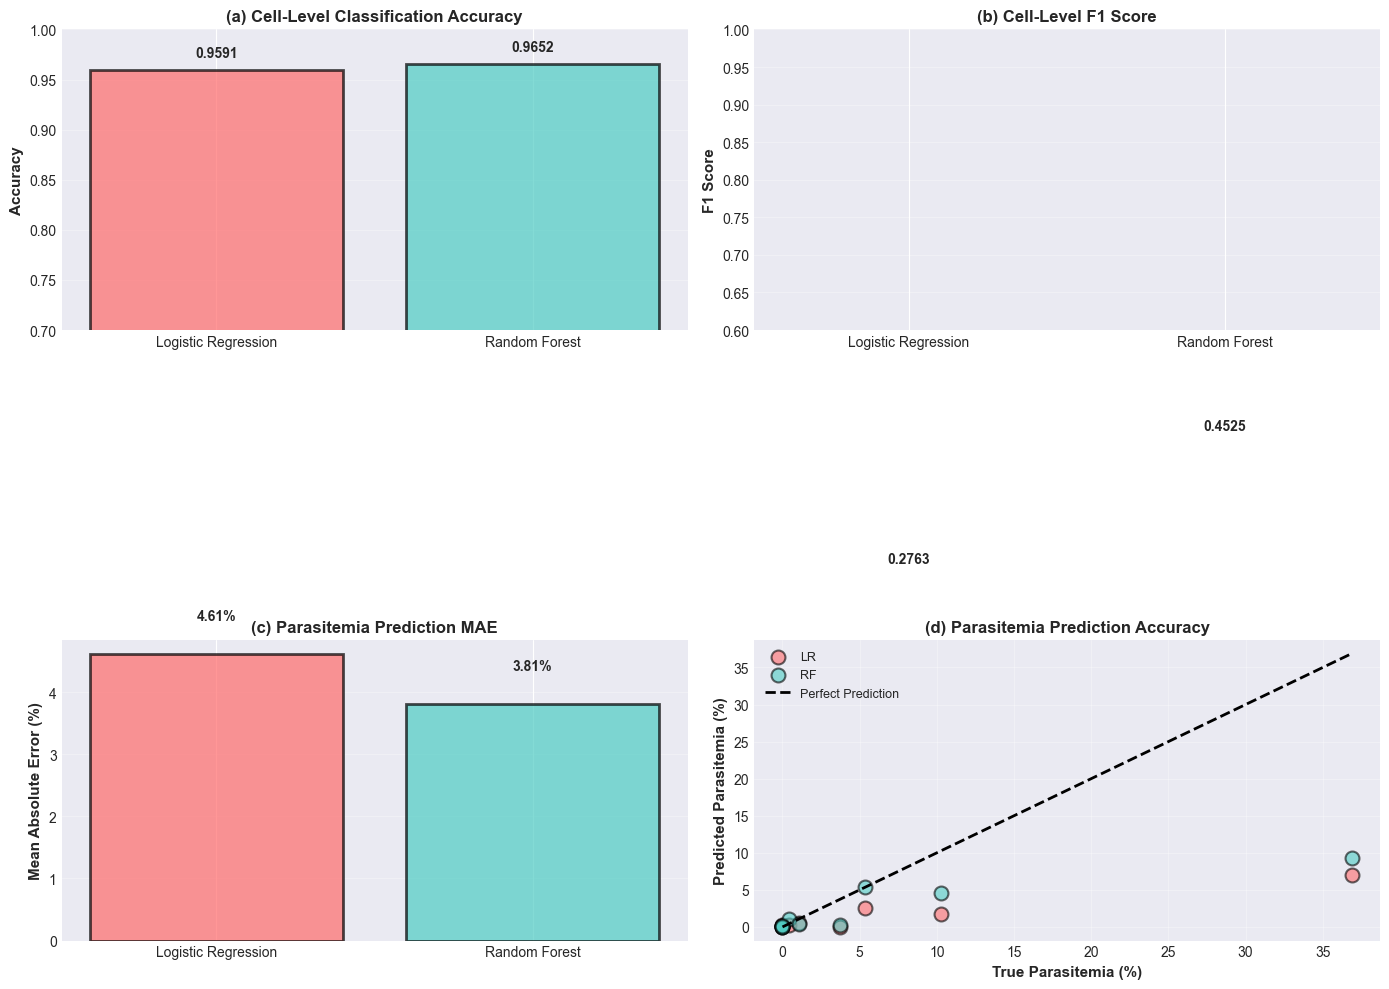


✓ Visualization saved to: plots/10_nih_polygon_model_comparison.png

FINAL SUMMARY: NIH-NLM POLYGON DATA MODEL COMPARISON
              Model Cell_Accuracy Cell_Precision Cell_Recall Cell_F1 Parasitemia_MAE Parasitemia_RMSE Training_Time_s
Logistic Regression        0.9591         0.7395      0.1699  0.2763         4.6105%          9.9096%            9.40
      Random Forest        0.9652         0.8182      0.3127  0.4525         3.8085%          8.9665%            0.91

✓ Summary table saved to: results/nih_polygon_model_summary.csv
✓ Trained models saved:
  - models/lr_nih_polygon_final.joblib
  - models/rf_nih_polygon_final.joblib

✓ NIH-NLM POLYGON TRAINING COMPLETE


In [23]:
# ============================================================================
# SECTION 5.4: NIH-NLM POLYGON DATA - TRAIN/TEST ON PATIENT LEVEL
# ============================================================================
# Objective 1: Predict individual cell infection status
# Objective 2: Predict parasitemia (% infected cells per patient)
# Train on 23 patients, test on 10 patients (held out)

print("\n" + "="*70)
print("SECTION 5.4: NIH-NLM POLYGON DATA - LR & RF MODEL TRAINING")
print("="*70)

if not dataset:
    print("⚠ No dataset loaded. Run the polygon processing cell first.")
else:
    # Get all patient IDs
    all_patient_ids = sorted(list(dataset.keys()))
    total_patients = len(all_patient_ids)
    
    print(f"\nTotal patients available: {total_patients}")
    print(f"Patients: {all_patient_ids}")
    
    # Hold out 10 patients for testing
    test_patients = random.sample(all_patient_ids, min(10, total_patients))
    train_patients = [p for p in all_patient_ids if p not in test_patients]
    
    print(f"\n{'='*70}")
    print(f"TRAIN/TEST SPLIT")
    print(f"{'='*70}")
    print(f"Training patients ({len(train_patients)}): {sorted(train_patients)}")
    print(f"Testing patients ({len(test_patients)}): {sorted(test_patients)}")
    
    # Extract features and labels from training patients
    print(f"\n{'='*70}")
    print(f"EXTRACTING FEATURES FROM TRAINING PATIENTS")
    print(f"{'='*70}")
    
    X_train_list = []
    y_train_list = []
    train_patient_ids = []
    
    for patient_id in train_patients:
        print(f"\nExtracting from {patient_id}...")
        segmented = extract_segmented_cells_from_dataset({patient_id: dataset[patient_id]}, padding=2, make_square=True)
        patient_cells = segmented.get(patient_id, [])
        
        if len(patient_cells) == 0:
            print(f"  ⚠ No cells for {patient_id}")
            continue
        
        for cell_data in patient_cells:
            cell_image = cell_data['image']
            gt_label = 1 if str(cell_data['label']).lower().startswith('para') else 0
            
            try:
                feature_vector = extract_features_from_image(cell_image, img_file=False)
                X_train_list.append(feature_vector)
                y_train_list.append(gt_label)
                train_patient_ids.append(patient_id)
            except Exception as e:
                continue
    
    X_train = np.array(X_train_list)
    y_train = np.array(y_train_list)
    
    print(f"\n✓ Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"  Infected cells: {np.sum(y_train == 1)}")
    print(f"  Uninfected cells: {np.sum(y_train == 0)}")
    
    # Extract features and labels from testing patients
    print(f"\n{'='*70}")
    print(f"EXTRACTING FEATURES FROM TESTING PATIENTS")
    print(f"{'='*70}")
    
    X_test_list = []
    y_test_list = []
    test_patient_ids = []
    
    for patient_id in test_patients:
        print(f"\nExtracting from {patient_id}...")
        segmented = extract_segmented_cells_from_dataset({patient_id: dataset[patient_id]}, padding=2, make_square=True)
        patient_cells = segmented.get(patient_id, [])
        
        if len(patient_cells) == 0:
            print(f"  ⚠ No cells for {patient_id}")
            continue
        
        for cell_data in patient_cells:
            cell_image = cell_data['image']
            gt_label = 1 if str(cell_data['label']).lower().startswith('para') else 0
            
            try:
                feature_vector = extract_features_from_image(cell_image, img_file=False)
                X_test_list.append(feature_vector)
                y_test_list.append(gt_label)
                test_patient_ids.append(patient_id)
            except Exception as e:
                continue
    
    X_test = np.array(X_test_list)
    y_test = np.array(y_test_list)
    
    print(f"\n✓ Testing data shape: X={X_test.shape}, y={y_test.shape}")
    print(f"  Infected cells: {np.sum(y_test == 1)}")
    print(f"  Uninfected cells: {np.sum(y_test == 0)}")
    
    # ========================================================================
    # OBJECTIVE 1: INDIVIDUAL CELL CLASSIFICATION
    # ========================================================================
    
    print(f"\n{'='*70}")
    print(f"OBJECTIVE 1: INDIVIDUAL CELL CLASSIFICATION")
    print(f"{'='*70}")
    
    # Train Logistic Regression
    print(f"\nTraining Logistic Regression on {len(X_train)} cells...")
    start_time = time.time()
    lr_model = LogisticRegression(max_iter=5000, random_state=42)
    lr_model.fit(X_train, y_train)
    lr_train_time = time.time() - start_time
    
    y_pred_lr = lr_model.predict(X_test)
    lr_acc = accuracy_score(y_test, y_pred_lr)
    lr_prec = precision_score(y_test, y_pred_lr, zero_division=0)
    lr_rec = recall_score(y_test, y_pred_lr, zero_division=0)
    lr_f1 = f1_score(y_test, y_pred_lr, zero_division=0)
    lr_cm = confusion_matrix(y_test, y_pred_lr)
    
    print(f"✓ LR Training Time: {lr_train_time:.2f}s")
    print(f"  Accuracy:  {lr_acc:.4f}")
    print(f"  Precision: {lr_prec:.4f}")
    print(f"  Recall:    {lr_rec:.4f}")
    print(f"  F1-Score:  {lr_f1:.4f}")
    print(f"  Confusion Matrix:\n{lr_cm}")
    
    # Train Random Forest
    print(f"\nTraining Random Forest on {len(X_train)} cells...")
    start_time = time.time()
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_train_time = time.time() - start_time
    
    y_pred_rf = rf_model.predict(X_test)
    rf_acc = accuracy_score(y_test, y_pred_rf)
    rf_prec = precision_score(y_test, y_pred_rf, zero_division=0)
    rf_rec = recall_score(y_test, y_pred_rf, zero_division=0)
    rf_f1 = f1_score(y_test, y_pred_rf, zero_division=0)
    rf_cm = confusion_matrix(y_test, y_pred_rf)
    
    print(f"✓ RF Training Time: {rf_train_time:.2f}s")
    print(f"  Accuracy:  {rf_acc:.4f}")
    print(f"  Precision: {rf_prec:.4f}")
    print(f"  Recall:    {rf_rec:.4f}")
    print(f"  F1-Score:  {rf_f1:.4f}")
    print(f"  Confusion Matrix:\n{rf_cm}")
    
    # Save individual cell prediction results
    cell_results = pd.DataFrame({
        'patient_id': test_patient_ids,
        'gt_label': y_test,
        'pred_lr': y_pred_lr,
        'pred_rf': y_pred_rf
    })
    
    cell_results.to_csv('results/nih_polygon_cell_predictions.csv', index=False)
    print(f"\n✓ Cell-level predictions saved to: results/nih_polygon_cell_predictions.csv")
    
    # ========================================================================
    # OBJECTIVE 2: PARASITEMIA ESTIMATION (PATIENT-LEVEL)
    # ========================================================================
    
    print(f"\n{'='*70}")
    print(f"OBJECTIVE 2: PARASITEMIA ESTIMATION (PATIENT-LEVEL)")
    print(f"{'='*70}")
    
    # Get unique test patients
    unique_test_patients = sorted(list(set(test_patient_ids)))
    
    parasitemia_results = []
    
    for patient_id in unique_test_patients:
        # Get all cells for this patient from test set
        patient_mask = np.array(test_patient_ids) == patient_id
        patient_y_true = y_test[patient_mask]
        patient_y_pred_lr = y_pred_lr[patient_mask]
        patient_y_pred_rf = y_pred_rf[patient_mask]
        
        # Calculate true parasitemia
        total_cells = len(patient_y_true)
        infected_cells_true = np.sum(patient_y_true == 1)
        parasitemia_true = (infected_cells_true / total_cells * 100) if total_cells > 0 else 0.0
        
        # Calculate predicted parasitemia (LR)
        infected_cells_lr = np.sum(patient_y_pred_lr == 1)
        parasitemia_lr = (infected_cells_lr / total_cells * 100) if total_cells > 0 else 0.0
        
        # Calculate predicted parasitemia (RF)
        infected_cells_rf = np.sum(patient_y_pred_rf == 1)
        parasitemia_rf = (infected_cells_rf / total_cells * 100) if total_cells > 0 else 0.0
        
        # Calculate error
        parasitemia_error_lr = abs(parasitemia_true - parasitemia_lr)
        parasitemia_error_rf = abs(parasitemia_true - parasitemia_rf)
        
        parasitemia_results.append({
            'patient_id': patient_id,
            'total_cells': total_cells,
            'infected_cells_true': infected_cells_true,
            'parasitemia_true': parasitemia_true,
            'infected_cells_lr': infected_cells_lr,
            'parasitemia_lr': parasitemia_lr,
            'parasitemia_error_lr': parasitemia_error_lr,
            'infected_cells_rf': infected_cells_rf,
            'parasitemia_rf': parasitemia_rf,
            'parasitemia_error_rf': parasitemia_error_rf
        })
    
    df_parasitemia = pd.DataFrame(parasitemia_results)
    
    print(f"\nParsitemia Results for {len(df_parasitemia)} Test Patients:")
    print(df_parasitemia.to_string(index=False))
    
    # Calculate parasitemia prediction metrics
    mae_lr = np.mean(df_parasitemia['parasitemia_error_lr'])
    mae_rf = np.mean(df_parasitemia['parasitemia_error_rf'])
    rmse_lr = np.sqrt(np.mean(df_parasitemia['parasitemia_error_lr']**2))
    rmse_rf = np.sqrt(np.mean(df_parasitemia['parasitemia_error_rf']**2))
    
    print(f"\n{'='*70}")
    print(f"PARASITEMIA PREDICTION METRICS")
    print(f"{'='*70}")
    print(f"\nLogistic Regression:")
    print(f"  Mean Absolute Error (MAE): {mae_lr:.4f}%")
    print(f"  Root Mean Squared Error (RMSE): {rmse_lr:.4f}%")
    
    print(f"\nRandom Forest:")
    print(f"  Mean Absolute Error (MAE): {mae_rf:.4f}%")
    print(f"  Root Mean Squared Error (RMSE): {rmse_rf:.4f}%")
    
    # Save parasitemia results
    df_parasitemia.to_csv('results/nih_polygon_parasitemia_predictions.csv', index=False)
    print(f"\n✓ Parasitemia predictions saved to: results/nih_polygon_parasitemia_predictions.csv")
    
    # ========================================================================
    # VISUALIZATION
    # ========================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Individual Cell Classification - Accuracy Comparison
    ax = axes[0, 0]
    models = ['Logistic Regression', 'Random Forest']
    accuracies = [lr_acc, rf_acc]
    colors = ['#FF6B6B', '#4ECDC4']
    bars = ax.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax.set_title('(a) Cell-Level Classification Accuracy', fontsize=12, fontweight='bold')
    ax.set_ylim([0.7, 1.0])
    ax.grid(True, alpha=0.3, axis='y')
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f'{acc:.4f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Individual Cell Classification - F1 Score Comparison
    ax = axes[0, 1]
    f1_scores = [lr_f1, rf_f1]
    bars = ax.bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
    ax.set_title('(b) Cell-Level F1 Score', fontsize=12, fontweight='bold')
    ax.set_ylim([0.6, 1.0])
    ax.grid(True, alpha=0.3, axis='y')
    for bar, f1 in zip(bars, f1_scores):
        ax.text(bar.get_x() + bar.get_width()/2, f1 + 0.01, f'{f1:.4f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 3. Parasitemia Prediction - MAE Comparison
    ax = axes[1, 0]
    mae_values = [mae_lr, mae_rf]
    bars = ax.bar(models, mae_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Mean Absolute Error (%)', fontsize=11, fontweight='bold')
    ax.set_title('(c) Parasitemia Prediction MAE', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for bar, mae in zip(bars, mae_values):
        ax.text(bar.get_x() + bar.get_width()/2, mae + 0.5, f'{mae:.2f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 4. Parasitemia True vs Predicted (scatter plot with both models)
    ax = axes[1, 1]
    ax.scatter(df_parasitemia['parasitemia_true'], df_parasitemia['parasitemia_lr'], 
              s=100, alpha=0.6, color='#FF6B6B', label='LR', edgecolor='black', linewidth=1.5)
    ax.scatter(df_parasitemia['parasitemia_true'], df_parasitemia['parasitemia_rf'], 
              s=100, alpha=0.6, color='#4ECDC4', label='RF', edgecolor='black', linewidth=1.5)
    
    # Perfect prediction line
    min_val = min(df_parasitemia['parasitemia_true'].min(), 
                  df_parasitemia['parasitemia_lr'].min(), 
                  df_parasitemia['parasitemia_rf'].min())
    max_val = max(df_parasitemia['parasitemia_true'].max(), 
                  df_parasitemia['parasitemia_lr'].max(), 
                  df_parasitemia['parasitemia_rf'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('True Parasitemia (%)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Parasitemia (%)', fontsize=11, fontweight='bold')
    ax.set_title('(d) Parasitemia Prediction Accuracy', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/10_nih_polygon_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Visualization saved to: plots/10_nih_polygon_model_comparison.png")
    
    # ========================================================================
    # SUMMARY TABLE
    # ========================================================================
    
    print(f"\n{'='*70}")
    print(f"FINAL SUMMARY: NIH-NLM POLYGON DATA MODEL COMPARISON")
    print(f"{'='*70}")
    
    summary_table = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest'],
        'Cell_Accuracy': [f'{lr_acc:.4f}', f'{rf_acc:.4f}'],
        'Cell_Precision': [f'{lr_prec:.4f}', f'{rf_prec:.4f}'],
        'Cell_Recall': [f'{lr_rec:.4f}', f'{rf_rec:.4f}'],
        'Cell_F1': [f'{lr_f1:.4f}', f'{rf_f1:.4f}'],
        'Parasitemia_MAE': [f'{mae_lr:.4f}%', f'{mae_rf:.4f}%'],
        'Parasitemia_RMSE': [f'{rmse_lr:.4f}%', f'{rmse_rf:.4f}%'],
        'Training_Time_s': [f'{lr_train_time:.2f}', f'{rf_train_time:.2f}']
    })
    
    print(summary_table.to_string(index=False))
    
    # Export summary table
    summary_table.to_csv('results/nih_polygon_model_summary.csv', index=False)
    print(f"\n✓ Summary table saved to: results/nih_polygon_model_summary.csv")
    
    # Save trained models
    dump(lr_model, 'models/lr_nih_polygon_final.joblib')
    dump(rf_model, 'models/rf_nih_polygon_final.joblib')
    print(f"✓ Trained models saved:")
    print(f"  - models/lr_nih_polygon_final.joblib")
    print(f"  - models/rf_nih_polygon_final.joblib")
    
    print(f"\n{'='*70}")
    print(f"✓ NIH-NLM POLYGON TRAINING COMPLETE")
    print(f"{'='*70}")